# Linear model 
Tobias C. Haase \
Master's student of Psychology at [Goethe-University Frankfurt](https://www.goethe-university-frankfurt.de/en?locale=en)


Dataset: [Abrupt hippocampal remapping signals resolution of memory interference](https://openneuro.org/datasets/ds003707/versions/1.0.0)


Previous exploration was performed using unpreprocessed data. Now, the data has (partially) been preprocessed - and the quality has been checked. 

Quality controle was performed using the [Magnetic Resoncance Imaging Quality Controle pipeline](https://mriqc.readthedocs.io/en/latest/) (22.0.6). 

The preprocessing was performed using [fMRI-Prep](https://fmriprep.org/en/stable/) (20.2.3)

Fistly I will load a preprocessed image. Then, going from the previously explored event files, I will outline the experimental paradigm and thus define contrasts. These will then be used for a generalized linear model (GLM).

I will first do the linear model for subject 1 to see if everything works. 

In [1]:
#Import of things I need later:
import os

In [2]:
#File paths
fmri_img_run1_sub1_path = '/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/derivatives/proj-63a02e876881d56fbfdeddfd/sub-01/dt-neuro-func-task.tag-scene.tag-preprocessed.run-01.id-63a40c34110972a28a63a1be/bold.nii.gz'
anat__img_run1_sub1_path = '/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/derivatives/proj-63a02e876881d56fbfdeddfd/sub-01/dt-neuro-anat-t1w.tag-preprocessed.run-01.id-63a40c34110972a28a639ef6/t1.nii.gz'

I have now the file paths to the mri images. Now I still need the event files to define respective contrasts. 


In [3]:
events_run1_sub1_path = '/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/ds003707/sub-01/func/sub-01_task-scene_run-01_events.tsv'

import pandas as pd
events_run1_sub1 = pd.read_table(events_run1_sub1_path)

events_run1_sub1


,onset,duration,correct,trial_type,response_time
0,10,4,0.0,1_B17,NaN
1,14,4,1.0,1_B16,0.585002
2,18,4,1.0,1_B4,0.752231
3,22,4,1.0,1_A7,0.869124
4,26,4,1.0,1_B5,0.434689
...,...,...,...,...,...
73,324,4,1.0,foil05,0.451596
74,328,4,1.0,2_A3,0.685084
75,332,4,1.0,2_B16,0.902571
76,336,4,0.0,2_B5,0.651940


In [4]:
events_run1_sub1 = events_run1_sub1[["onset", "duration", "trial_type"]]
for i, row in events_run1_sub1.iterrows():
    events_run1_sub1["trial_type"][i] = events_run1_sub1["trial_type"][i].replace('1_', '') ;
    events_run1_sub1["trial_type"][i] = events_run1_sub1["trial_type"][i].replace('2_', '') ;

events_run1_sub1["trial_type"].unique()

events_run1_sub1 = events_run1_sub1[["onset", "duration", "trial_type"]]

/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in 

Each trial has a certain onset, the same duration and then the response is either correct or not correct. 
We also see that there is a certain response time - if this is failed the trial is listed to be `0.0` i.e. not correct. 

Now, lets generate a design matrix with these event files. Recall that a 'design matrix' is a matrix that contains the explanatory variables. Here, the explanatory variables also involes the regressors that are the result of the previously mentioned pipelines!

In [5]:
from nilearn.glm.first_level import FirstLevelModel ;

#Now I need the TR and other parameters. I previously extracted them using the 'pybids module!' 

import nibabel as nib ;

fmri_img_run1_sub1 = nib.load(fmri_img_run1_sub1_path);
#The get_zooms function contains voxel size with the 4th entry being the time, this is therefore the repititon time!
fmri_img_run1_sub1.header.get_zooms()[3] ;

/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


Knowing the repition time, we can set up the `FirstLevelModel`.

A few parameters that were choosen I will explain:
- `Drift mode`: It's a `cosine functio` that aims to remove effects of heart rate etc. The standard setting here is 1/128 Hz. In the design matrix this will end up as a column with almost no change in color, only very slight drift!
- The hrf-model part specifies the`hemodynamic response model`: The event file has certain events, but this needs to be converted into a ["reference BOLD signal for the design matrix"](https://nilearn.github.io/dev/auto_examples/04_glm_first_level/plot_first_level_details.html). Here the basic wasn't choosen, but the `spm`. This stands for statistical parametric map? In contrast to the basic the undershoot following the haemondynamic response is said to be weaker here.
- As the drift model is cosine, a high pass filter can be applied. The high pass filter will let [higher frequencies pass](https://www.brainvoyager.com/bv/doc/UsersGuide/Preprocessing/TemporalHighPassFiltering.html), the cut-off here is set to another value than the standard! What does this mean? I will have an additional confound with the lower frequencies, them being included in the model instead of them being removed!
&nbsp;


- Noise model: There are different options for noise models. The `ar1` is the preset noise model. A ordinary least squared approach, autoregressive approaches of higher order or other models could have been used. 
&nbsp;


- No sample mask was applied! For example a mask could be appplied to exclude unwanted volumes (i.e. volume censoring). A mask could also be applied to specifiy a region of interest! I will try to apply a hippocampus related mask later, as the data is only partial data. 
&nbsp;


- I don't want the signal to be scaled, so this is set to false!

In [6]:
fmri_glm_run1_sub1 = FirstLevelModel(t_r=2.5,
                           noise_model='ar1',
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=1./160,
                           signal_scaling=False,
                           minimize_memory=False)

This model still lacks the confounds.

In [7]:
import pandas as pd
import numpy as np
confounds_run1_sub1 = pd.read_csv('/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/derivatives/proj-63a02e876881d56fbfdeddfd/sub-01/dt-neuro-regressors.run-01.id-63a40bfe110972a28a63792d/regressors.tsv', 
                                  delimiter = '\t')
#The delimiter needs to be set to \t as it uses tab to differentiate different entries. 

column_names = list(confounds_run1_sub1.columns.values)
column_names

['global_signal',
 'global_signal_derivative1',
 'global_signal_derivative1_power2',
 'global_signal_power2',
 'csf',
 'csf_derivative1',
 'csf_power2',
 'csf_derivative1_power2',
 'white_matter',
 'white_matter_derivative1',
 'white_matter_derivative1_power2',
 'white_matter_power2',
 'csf_wm',
 'tcompcor',
 'std_dvars',
 'dvars',
 'framewise_displacement',
 'rmsd',
 't_comp_cor_00',
 't_comp_cor_01',
 't_comp_cor_02',
 't_comp_cor_03',
 't_comp_cor_04',
 't_comp_cor_05',
 't_comp_cor_06',
 't_comp_cor_07',
 't_comp_cor_08',
 't_comp_cor_09',
 't_comp_cor_10',
 't_comp_cor_11',
 't_comp_cor_12',
 'a_comp_cor_00',
 'a_comp_cor_01',
 'a_comp_cor_02',
 'a_comp_cor_03',
 'a_comp_cor_04',
 'a_comp_cor_05',
 'a_comp_cor_06',
 'a_comp_cor_07',
 'a_comp_cor_08',
 'a_comp_cor_09',
 'a_comp_cor_10',
 'a_comp_cor_11',
 'a_comp_cor_12',
 'a_comp_cor_13',
 'a_comp_cor_14',
 'a_comp_cor_15',
 'a_comp_cor_16',
 'a_comp_cor_17',
 'a_comp_cor_18',
 'a_comp_cor_19',
 'a_comp_cor_20',
 'a_comp_cor_21',


Only a portion of the entries are needed here. 

The following are extracted, following the recommedation from the [fmriprep-doc](https://fmriprep.org/en/stable/outputs.html#confounds). 
- The parameters of head motion, i.e. the transverse and rotational movements. `trans_x`, `trans_y`, `trans_z`, `rot_x`, `rot_y`, `rot_z`.

&nbsp;
The following three are copy-pastad from said website:
- `csf - the average signal within anatomically-derived eroded CSF mask`
- `white_matter - the average signal within the anatomically-derived eroded WM masks`
-  `global_signal - the average signal within the brain mask`

- the rmsd - this also takes head motion into account but using a different statistical approach.
- framewise_displacement - another classic measure of movement. 

As a high-pass filter is included, I will not include regressors for signal drift. 

In [8]:
confounds_glm_run1_sub1 = confounds_run1_sub1[['white_matter', 'global_signal', 'framewise_displacement','csf', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'rmsd']].replace(np.nan, 0)
confounds_glm_run1_sub1

,white_matter,global_signal,framewise_displacement,csf,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,rmsd
0,6112.850510,5778.613968,0.000000,9322.129990,-0.000034,0.020300,-0.049074,0.001069,-0.000195,0.000403,0.000000
1,6110.728298,5771.078983,0.145461,9253.195564,0.008608,-0.042165,0.012557,0.001057,-0.000335,0.000506,0.088852
2,6105.869879,5772.532507,0.167451,9230.427054,0.008898,0.042510,-0.047804,0.000871,-0.000181,0.000403,0.103671
3,6111.159442,5781.951719,0.151063,9225.747118,0.006653,-0.037633,0.013603,0.000963,-0.000234,0.000403,0.100546
4,6104.351970,5779.417069,0.132056,9198.068809,0.006777,0.029214,-0.037018,0.000908,-0.000000,0.000403,0.084507
...,...,...,...,...,...,...,...,...,...,...,...
172,6073.001622,5769.604286,0.108251,9305.441074,-0.014610,0.155543,0.035509,-0.004062,0.000778,-0.001068,0.065483
173,6078.543060,5765.983081,0.108225,9379.008402,-0.016201,0.218181,0.016423,-0.004373,0.000924,-0.001109,0.067141
174,6082.540949,5768.195460,0.089100,9336.754697,-0.015434,0.169284,0.027389,-0.003997,0.000848,-0.000992,0.053637
175,6076.835386,5768.193978,0.085398,9367.921147,-0.010949,0.214071,0.027454,-0.004589,0.000970,-0.000986,0.055468


I have now specified the confounds I will need. Now lets run the model!

In [9]:
fmri_glm_run1_sub1 = fmri_glm_run1_sub1.fit(fmri_img_run1_sub1_path, events_run1_sub1, confounds_glm_run1_sub1)

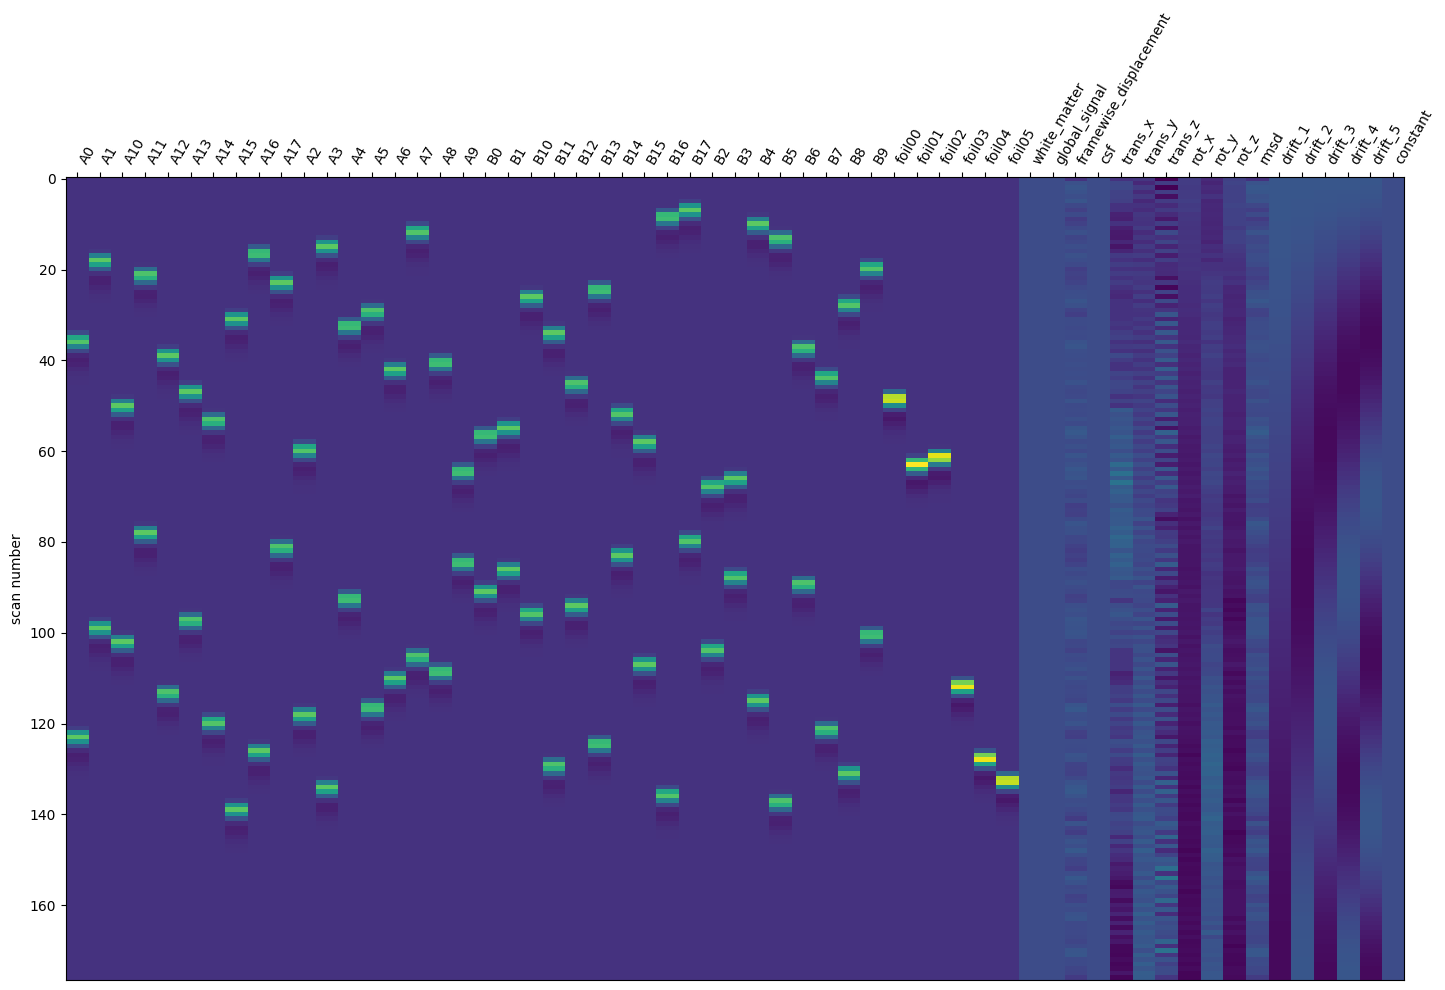

In [10]:
design_matrix = fmri_glm_run1_sub1.design_matrices_[0]

from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrix)
import matplotlib.pyplot as plt
plt.show()

Importantly the contrast does not depend on the correct recall but there are always scene pairs: What helps them being differentiated in memory?